In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import albumentations as A
from sklearn import preprocessing 
import glob

In [2]:
df = pd.read_csv("_annotations.csv")

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
len(df)

3828

In [5]:
df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,2023-07-19-19-37-47-996_PNG.rf.a5c5af7b43a0753...,640,640,House,0,313,252,640
1,2023-07-19-19-37-47-996_PNG.rf.a5c5af7b43a0753...,640,640,House,190,93,513,334
2,2023-07-19-19-37-47-996_PNG.rf.a5c5af7b43a0753...,640,640,Pole,370,165,398,481
3,2023-07-19-19-37-47-996_PNG.rf.a5c5af7b43a0753...,640,640,Fence,143,331,269,424
4,2023-07-19-19-37-47-996_PNG.rf.a5c5af7b43a0753...,640,640,Fence,106,310,133,343
...,...,...,...,...,...,...,...,...
3823,2023-07-20-11-24-40-975_PNG.rf.82fd8488f1581f5...,640,640,Fence,0,447,106,539
3824,2023-07-20-11-24-40-975_PNG.rf.82fd8488f1581f5...,640,640,Fence,108,325,170,462
3825,2023-07-20-11-24-40-975_PNG.rf.82fd8488f1581f5...,640,640,Fence,0,234,121,378
3826,2023-07-20-11-24-40-975_PNG.rf.82fd8488f1581f5...,640,640,Tree,149,0,243,332


In [6]:
transform = A.Compose([
    A.RandomCrop(width=128, height=128),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomGamma(p=0.2),
    A.Blur(p=0.2),
    A.GaussNoise(p=0.2),
    A.ToFloat(max_value=255)
])


In [7]:
a=df["class"].unique()

In [8]:
print(a)

['House' 'Pole' 'Fence' 'Tree' 'Street Sign' 'Building']


In [9]:
le = preprocessing.LabelEncoder()

In [10]:
df['class']= le.fit_transform(df['class']) 

In [14]:
df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,2023-07-19-19-37-47-996_PNG.rf.a5c5af7b43a0753...,640,640,2,0,313,252,640
1,2023-07-19-19-37-47-996_PNG.rf.a5c5af7b43a0753...,640,640,2,190,93,513,334
2,2023-07-19-19-37-47-996_PNG.rf.a5c5af7b43a0753...,640,640,3,370,165,398,481
3,2023-07-19-19-37-47-996_PNG.rf.a5c5af7b43a0753...,640,640,1,143,331,269,424
4,2023-07-19-19-37-47-996_PNG.rf.a5c5af7b43a0753...,640,640,1,106,310,133,343
...,...,...,...,...,...,...,...,...
3823,2023-07-20-11-24-40-975_PNG.rf.82fd8488f1581f5...,640,640,1,0,447,106,539
3824,2023-07-20-11-24-40-975_PNG.rf.82fd8488f1581f5...,640,640,1,108,325,170,462
3825,2023-07-20-11-24-40-975_PNG.rf.82fd8488f1581f5...,640,640,1,0,234,121,378
3826,2023-07-20-11-24-40-975_PNG.rf.82fd8488f1581f5...,640,640,5,149,0,243,332


In [11]:
df["class"].unique()

array([2, 3, 1, 5, 4, 0])

In [30]:
obj={"img":[], "label":[]}
for i in range(len(df)):
    path = os.path.join("train_data", df["filename"][i])
    try:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)
        obj["img"].append(img)
        obj["label"].append(df["class"][i])
    except:
        continue

In [60]:
def agu(img):
    return transform(image=img)["image"]
for i in range(len(obj["img"])):
    obj["img"].append(agu(obj["img"][i]))
    obj["label"].append(obj["label"][i])
    


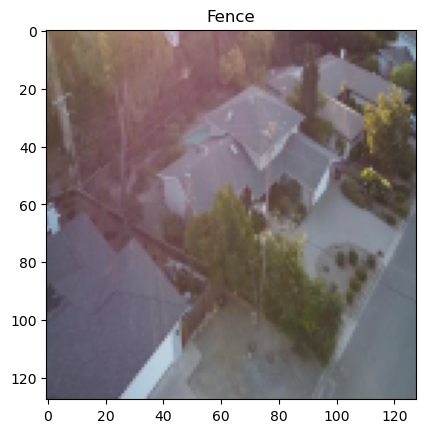

In [13]:
plt.imshow(obj["img"][0])
plt.title(a[obj["label"][0]])
plt.show()


In [38]:
# creating a modle using transfer learing to detect the obsticle
with tf.device('/gpu:0'):
    base_model = tf.keras.applications.ResNet50(input_shape=(32,32, 3), include_top=False, weights=None)
    img = tf.keras.layers.Input(shape=(32,32,3))
    x = base_model(img)
    x=tf.keras.layers.Flatten()(x)
    y = tf.keras.layers.Dense(128, activation='relu')(x)
    y = tf.keras.layers.Dropout(0.2)(y)
    y=tf.keras.layers.Dense(10,activation='softmax')(y)
    model = tf.keras.Model(inputs=[img], outputs=y)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

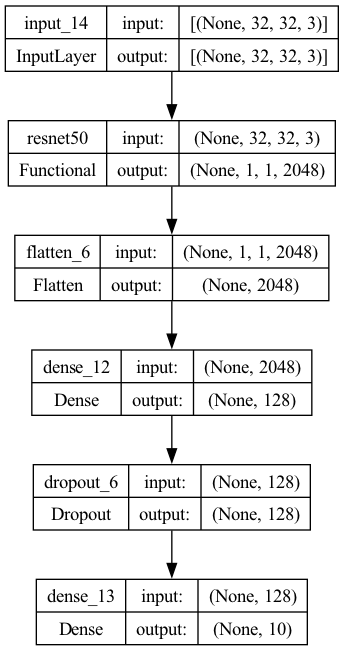

In [39]:
#architecture of our proposed modle
tf.keras.utils.plot_model(model, show_shapes=True)

In [40]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               262272    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 10)                1290      
                                                                 
Total params: 23,851,274
Trainable params: 23,798,154
Non-t

In [41]:

obj["label"]=np.array(obj["label"])

In [42]:
obj["img"]=np.array(obj["img"])
obj["img"].shape

(3828, 32, 32, 3)

In [43]:
obj["label"].shape

(3828,)

In [44]:
ret= model.fit(x=obj["img"],y=obj["label"], epochs=5, batch_size=10, verbose=1)

Epoch 1/5
383/383 [==============================] - 48s 103ms/step - loss: 1.6721 - accuracy: 0.4718
Epoch 2/5
383/383 [==============================] - 28s 72ms/step - loss: 1.4496 - accuracy: 0.5246
Epoch 3/5
383/383 [==============================] - 26s 68ms/step - loss: 1.3895 - accuracy: 0.5327
Epoch 4/5
383/383 [==============================] - 26s 68ms/step - loss: 1.3697 - accuracy: 0.5345
Epoch 5/5
383/383 [==============================] - 27s 70ms/step - loss: 1.3393 - accuracy: 0.5363


In [45]:
ret.history.keys()


dict_keys(['loss', 'accuracy'])

KeyError: 'val_accuracy'

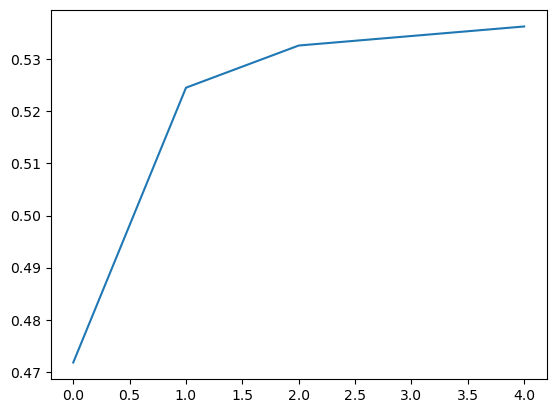

In [46]:
plt.plot(ret.history['accuracy'])
plt.plot(ret.history['val_accuracy'])

In [50]:
#our model gives acc of 55%
score = model.evaluate(obj["img"], obj["label"], verbose=1)

120/120 [==============================] - 7s 54ms/step - loss: 1.2466 - accuracy: 0.5499


In [51]:
model.save("model.h5")

120/120 [==============================] - 5s 27ms/step


Text(0.5, 1.0, 'Confusion Matrix')

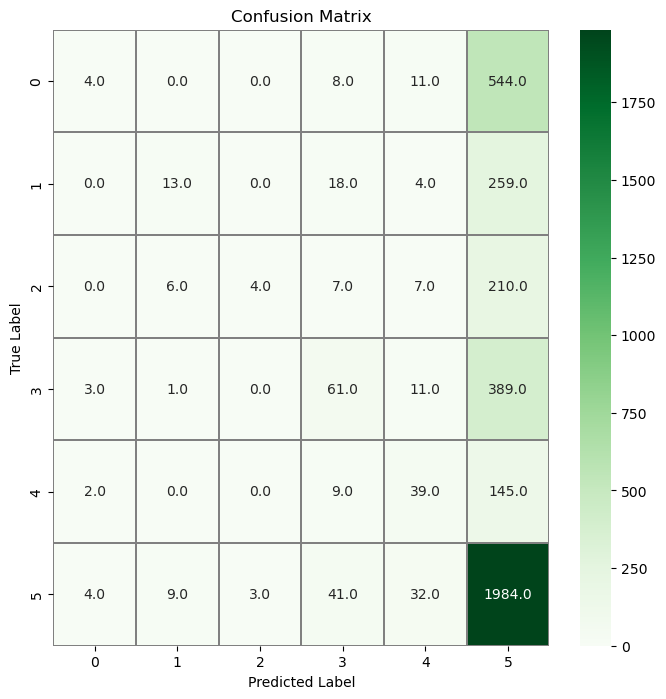

In [49]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = model.predict(obj["img"])
y_pred_classes = np.argmax(y_pred,axis = 1)
y_true = obj["label"]
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")


In [59]:
a[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [31]:
j=0
for i in range(len(a)):
   if np.argmax(a[i])==obj["label"][i]:
       j+=1

In [32]:
j/len(a)

0.10108580762948016

In [5]:
model=tf.keras.models.load_model("resnet.h5")